# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [ ]:
%pip install pyrosm keplergl haversine pandas numpy

In [57]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
from copy import deepcopy
from tqdm import tqdm


from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [5]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the data
pasdaran_streets = pd.read_csv('/content/drive/My Drive/AI/project/AI_project_phase_1/pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('/content/drive/My Drive/AI/project/AI_project_phase_1/pasdaran_nodes.csv')

In [ ]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [ ]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [ ]:

pasdaran_map = KeplerGl(height=600, width=800)

pasdaran_map.add_data(data=pasdaran_streets, name='pasdaran_streets')

pasdaran_map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'pasdaran_streets': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [ ]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [15]:
# TODO: You should implement this from scratch and you cannot use any library (such as networkx) for finding the shortest path.
from collections import defaultdict
import heapq


def find_shotest_path(start, end, graph) :
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """

    def create_graph(df):
      graph = defaultdict(dict)
      for row in range(len(df)):
        graph[df.iloc[row]['u']][df.iloc[row]['v']] = df.iloc[row]['length']
        graph[df.iloc[row]['v']][df.iloc[row]['u']] = df.iloc[row]['length']

      else:
        for key in graph.keys():
          graph[key] = (graph[key],None)

        # check the created graph
        assert np.unique(np.concatenate((df['u'],df['v']))).shape[0] == len(graph.keys())
        return graph


    s_lat, s_lon = start
    d_lat, d_lon = end

    if graph[(graph['u_lat']==s_lat) & (graph['u_lon']==s_lon)]['u'].shape[0] > 0:
      start_node = graph[(graph['u_lat']==s_lat) & (graph['u_lon']==s_lon)]['u'].values[0]
    elif graph[(graph['v_lat']==s_lat) & (graph['v_lon']==s_lon)]['v'].shape[0] > 0:
      start_node = graph[(graph['v_lat']==s_lat) & (graph['v_lon']==s_lon)]['v'].values[0]

    if graph[(graph['u_lat']==d_lat) & (graph['u_lon']==d_lon)]['u'].shape[0] > 0:
      end_node = graph[(graph['u_lat']==d_lat) & (graph['u_lon']==d_lon)]['u'].values[0]
    elif graph[(graph['v_lat']==d_lat) & (graph['v_lon']==d_lon)]['v'].shape[0] > 0:
      end_node = graph[(graph['v_lat']==d_lat) & (graph['v_lon']==d_lon)]['v'].values[0]

    graph = create_graph(graph)

    # Initialize distances for all nodes
    distances = {node: np.inf for node in graph}
    distances[start_node] = 0

    my_queue = [(0, start_node)]

    while my_queue:
        curr_distance, curr_node = heapq.heappop(my_queue)

        if curr_node == end_node:
            path = []
            while curr_node is not None:
                path.append(curr_node)
                curr_node = graph[curr_node][1]
            return path[::-1]  # This returns the shortest path found

        if curr_distance > distances[curr_node]:  # Check if current distance is greater than stored distance, then continue
            continue

        zip_ = graph[curr_node][0].items()  # Retrieve the neighbors and their weights

        for neighb, weight in zip_:
            distance = curr_distance + weight
            if distance < distances[neighb]:  # If the new distance is smaller than the stored distance, update the distance and path
                distances[neighb] = distance
                graph[neighb] = (graph[neighb][0], curr_node)  # Update the path to the neighbor
                heapq.heappush(my_queue, (distance, neighb))  # Add the neighbor to the queue with the updated distance


    return None



In [16]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


Save the location of the nodes

In [17]:
node_location = dict()
for node in range(pasdaran_streets.shape[0]):
  node_location[pasdaran_streets['u'][node]] = {'lat':pasdaran_streets['u_lat'][node], 'lon':pasdaran_streets['u_lon'][node]}
  node_location[pasdaran_streets['v'][node]] = {'lat':pasdaran_streets['v_lat'][node], 'lon':pasdaran_streets['v_lon'][node]}


You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [18]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

# TODO: Implement and print out a sample trip
node1 = np.random.randint(0,pasdaran_streets.shape[0])
node2 = np.random.randint(0,pasdaran_streets.shape[0])

node1_lat,node1_lon = pasdaran_streets['u_lat'][node1], pasdaran_streets['u_lon'][node1]
node2_lat,node2_lon = pasdaran_streets['u_lat'][node2], pasdaran_streets['u_lon'][node2]

print(node1_lat,node1_lon,node2_lat,node2_lon)

35.778316497802734 51.44009780883789 35.76906967163086 51.4406623840332


In [19]:
sampled_trip = find_shotest_path((node1_lat,node1_lon),(node2_lat,node2_lon),pasdaran_streets)
print(sampled_trip)

[1725215743, 4705330056, 1725215733, 4705330059, 423830745, 1725215725, 4692318251, 4692318259, 8243063383, 423816888, 4698367370, 423816889, 4698367369, 4698367368, 5726748645, 4698367363, 423816890, 423815710, 4698380304, 4698380301, 423815709, 4548912086, 4548912079, 423813731, 3405484875, 423816741, 4695866630, 9766894901, 4683382421, 4683382422, 4683382428, 4683382424, 4683382423, 4695837549, 4695837547, 423816401, 4683382419, 2170381978, 2170382317, 2170381701, 3844136667, 2170381783, 11158587870, 9767680732, 2170382258, 2170382310, 2170381661]


In [20]:
def create_path_df(trip,df):
  timestep = [0.0]
  for index in range(len(trip)-1):
    if df[(df['u'] == trip[index]) & (df['v'] == trip[index+1])].shape[0] > 0:
      timestep.append(df[(df['u'] == trip[index]) & (df['v'] == trip[index+1])]['length'].values[0] )
    elif df[(df['v'] == trip[index]) & (df['u'] == trip[index+1])].shape[0] > 0:
      timestep.append(df[(df['v'] == trip[index]) & (df['u'] == trip[index+1])]['length'].values[0] )
    else :
      assert False

  lats = [node_location[node]['lat'] for node in trip]
  lons = [node_location[node]['lon'] for node in trip]

  data = {'node_is': trip,
          'lat': lats,
          'lon': lons}
  output = pd.DataFrame(data)

  # cumulative sum of a length vector
  output['timestep'] = np.cumsum(timestep)
  output['timestep'] = output['timestep'].round(3).astype(float)

  return output

In [21]:
create_path_df(sampled_trip,pasdaran_streets).head()

,node_is,lat,lon,timestep
0,1725215743,35.778316,51.440098,0.000
1,4705330056,35.777935,51.440132,42.530
2,1725215733,35.777592,51.440125,80.712
3,4705330059,35.776989,51.440163,147.820
4,423830745,35.776894,51.440170,158.447


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [22]:
#TODO: Visualize the sampled trip using kepler

map_1 = KeplerGl(height=600)
map_1.add_data(data=create_path_df(sampled_trip,pasdaran_streets), name='sampled_trip')
map_1


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'sampled_trip': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

$$\Delta X = V × \Delta t$$

$\text{Haversine formula: } \quad $

$$ haversin(\theta) = \sin^2\Bigg(\frac{d_{\text{lat}}}{2}\Bigg) + \cos(\text{lat}_1) \cdot \cos(\text{lat}_2) \cdot \sin^2\Bigg(\frac{d_{\text{long}}}{2}\Bigg)
$$


The Haversine formula for calculating the distance $d$ between two points on a sphere with radius $R$ is given by:

$$d = 2R \arcsin(haversin(θ))$$


In [332]:
import math
from haversine import haversine


EARTH_RADIUS = 6371

def calculate_distance(lat1, lon1, lat2, lon2):
    # Converting coordinates from degrees to radians
    lat1_rad, lat2_rad, lon1_rad, lon2_rad = map(math.radians, [lat1, lat2,lon1, lon2])

    # Calculating the differences in latitude and longitude
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    Haversine_ = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    distance = 2 * EARTH_RADIUS * math.asin(math.sqrt(Haversine_))

    # distance = haversine((lat1, lon1), (lat2, lon2))
    return distance


In [111]:
# calculate_distance(35.778316	,51.440098,35.528316,	51.550098)
# haversine((35.778316	,51.440098),(35.528316,	51.550098))

The **bearing** between two geographical points refers to the direction of the straight line that connects the two points.


Utilizing this formula, bearing can be calculated using the following formula:

$$
\begin{align*}
x & = \sin(\Delta\lambda) \times \cos(\phi_2) \\
y & = \cos(\phi_1) \times \sin(\phi_2) - (\sin(\phi_1) \times \cos(\phi_2) \times \cos(\Delta\lambda)) \\
\quad \text{bearing} & = \arctan2(x, y) \\
\text{bearing} & = (\text{degrees}(\text{bearing}) + 360) \% 360
\end{align*}
\\
$$

Where:
- $(\Delta\lambda)$ is the difference in longitude between the two points,
- $(\phi_1)$ and $(\phi_2)$ are the latitudes of the two points in radians,
- $(x)$ and $(y)$ are intermediate variables for calculation,
- $(\arctan2(x, y))$ returns the angle whose tangent is the quotient of the two specified numbers,
- $\text{degrees}()$, converts the angle from radians to degrees,
- The expression $((\text{degrees}(\text{bearing}) + 360) \% 360)$ is used to ensure that the resulting bearing angle falls within the range of 0 to 360 degrees.


In [333]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Converting coordinates from degrees to radians
    lat1_rad, lat2_rad, lon1_rad, lon2_rad = map(math.radians, [lat1, lat2,lon1, lon2])

    # Calculating the differences in latitude and longitude
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Calculating the bearing
    x = math.sin(dlon) * math.cos(lat2_rad)
    y = math.cos(lat1_rad) * math.sin(lat2_rad) - (math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(dlon))
    bearing = math.atan2(x, y)
    bearing = (math.degrees(bearing) + 360) % 360
    return bearing

Given initial coordinates: $( \text{lat}_1, \text{lon}_1 )$, the calculations then yield new destination coordinates: $( \text{lat}_2, \text{lon}_2 )$.

The formulas for the new destination coordinates are as follows:

$$
\text{lat}_2 = \arcsin\left(\sin(\text{lat}_1) \cdot \cos(\frac{\text{distance}}{\text{R}}) + \cos(\text{lat}_1) \cdot \sin(\frac{\text{distance}}{\text{R}}) \cdot \cos(\text{bearing}_{\text{rad}})\right)
$$

$$
\text{lon}_2 = \text{lon}_1 + \arctan2\left(\sin(\text{bearing}_{\text{rad}}) \cdot \sin(\frac{\text{distance}}{\text{R}}) \cdot \cos(\text{lat}_1), \cos(\frac{\text{distance}}{\text{R}}) - \sin(\text{lat}_1) \cdot \sin(\text{lat}_2)\right)
$$

In [334]:
def move_towards(lat1, lon1, lat2, lon2, distance):
    """
    Calculating the new destination coordinates using
    previous coordinates, bearing and distance.
    """
    # Calculating initial bearing
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)

    # Converting coordinates from degrees to radians
    lat1_rad, lon1_rad, bearing_rad = map(math.radians, [lat1, lon1, bearing])

    # Calculating the new destination coordinates
    lat2 = math.asin(math.sin(lat1_rad) * math.cos(distance/EARTH_RADIUS) + math.cos(lat1_rad) * math.sin(distance/EARTH_RADIUS) * math.cos(bearing_rad))
    lon2 = lon1_rad + math.atan2(math.sin(bearing_rad) * math.sin(distance/EARTH_RADIUS) * math.cos(lat1_rad), math.cos(distance/EARTH_RADIUS) - math.sin(lat1_rad) * math.sin(lat2))
    lat2, lon2 = map(math.degrees, [lat2, lon2])

    return lat2, lon2

In [114]:
def get_gps_samples(ride_speed, ride_gps_time, trip):

    junction_nodes = []
    for node in trip:
        junction_nodes.append((node,
                              pasdaran_nodes[pasdaran_nodes['id'] == node]['lat'],
                              pasdaran_nodes[pasdaran_nodes['id'] == node]['lon']))

    streets_lenght = []
    for i in range(len(junction_nodes) - 1):
        if pasdaran_streets[(pasdaran_streets['u'] == junction_nodes[i][0]) & (pasdaran_streets['v'] == junction_nodes[i + 1][0])].shape[0] > 0:
          streets_lenght.append(pasdaran_streets[(pasdaran_streets['u'] == junction_nodes[i][0]) & (pasdaran_streets['v'] == junction_nodes[i + 1][0])]['length'].values[0] )
        elif pasdaran_streets[(pasdaran_streets['v'] == junction_nodes[i][0]) & (pasdaran_streets['u'] == junction_nodes[i + 1][0])].shape[0] > 0:
          streets_lenght.append(pasdaran_streets[(pasdaran_streets['v'] == junction_nodes[i][0]) & (pasdaran_streets['u'] == junction_nodes[i + 1][0])]['length'].values[0] )
        else :
          assert False

    ride = []
    ride.append([junction_nodes[0][1].values[0], junction_nodes[0][2].values[0]])

    cur_pos = [junction_nodes[0][1], junction_nodes[0][2]]
    i = 0
    while i < len(junction_nodes) - 1:
        dist = ride_speed * ride_gps_time
        traveled_path = calculate_distance(cur_pos[0], cur_pos[1], junction_nodes[i + 1][1], junction_nodes[i + 1][2])
        while dist >= traveled_path:
            i += 1
            if i == len(junction_nodes) - 1:
                break
            dist -= traveled_path
            cur_pos = [junction_nodes[i][1], junction_nodes[i][2]]
            traveled_path = streets_lenght[i]

        if i == len(junction_nodes) - 1:
            break
        new_lat, new_lon = move_towards(cur_pos[0], cur_pos[1], junction_nodes[i + 1][1], junction_nodes[i + 1][2], dist)
        ride.append([new_lat, new_lon])

        cur_pos = [new_lat, new_lon]

    # final dest
    ride.append([junction_nodes[-1][1].values[0], junction_nodes[-1][2].values[0]])

    return np.array(ride)

In [115]:
speed = 10
time = 10

example_ride = get_gps_samples(speed, time, sampled_trip)
example_ride

array([[35.7783165 , 51.44009781],
       [35.77703688, 51.44015963],
       [35.77609161, 51.44013913],
       [35.77508732, 51.44060889],
       [35.77426853, 51.44117315],
       [35.77430255, 51.44242906],
       [35.77344878, 51.44277735],
       [35.77235982, 51.44292057],
       [35.77148478, 51.44272174],
       [35.77081363, 51.44186951],
       [35.77012611, 51.44065651],
       [35.76929392, 51.44108417],
       [35.76810739, 51.44145648],
       [35.76850905, 51.44105251],
       [35.76906967, 51.44066238]])

See a sample ride, printed out.

# animation

In [116]:
#TODO: Visualize the sampled ride using kepler

def visualize_a_ride(ride_speed, ride_gps_time, trip):
  example_ride = get_gps_samples(ride_speed, ride_gps_time, trip)
  data = {
      'latitude': example_ride[:,0],
      'longitude': example_ride[:,1],
      'timestep': np.arange(example_ride.shape[0])

      }

  df = pd.DataFrame(data)
  map_1 = KeplerGl(height=600, width=800)
  map_1.add_data(data=df, name='example_ride')

  return map_1



In [117]:
visualize_a_ride(speed, time, sampled_trip)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'columns': ['lati…

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [118]:
example_ride

array([[35.7783165 , 51.44009781],
       [35.77703688, 51.44015963],
       [35.77609161, 51.44013913],
       [35.77508732, 51.44060889],
       [35.77426853, 51.44117315],
       [35.77430255, 51.44242906],
       [35.77344878, 51.44277735],
       [35.77235982, 51.44292057],
       [35.77148478, 51.44272174],
       [35.77081363, 51.44186951],
       [35.77012611, 51.44065651],
       [35.76929392, 51.44108417],
       [35.76810739, 51.44145648],
       [35.76850905, 51.44105251],
       [35.76906967, 51.44066238]])

In [119]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
def add_noise(ride,gps_noise_radius):
  return ride + np.random.normal(0,gps_noise_radius,size=ride.shape[0]*ride.shape[1]).reshape(ride.shape[0],-1)

# Print out a sample
add_noise(example_ride,0.5)

array([[34.98619971, 50.16179439],
       [36.23146303, 50.33936737],
       [35.508946  , 51.49758512],
       [35.3098464 , 50.9290651 ],
       [36.05299279, 51.13406208],
       [35.43810696, 51.10764941],
       [35.67836514, 50.95160239],
       [36.06388557, 49.77517919],
       [36.33801354, 52.67563563],
       [34.9678139 , 51.23678284],
       [36.6184978 , 51.56302355],
       [35.22745666, 51.49133239],
       [35.57134856, 51.14376874],
       [36.01284333, 51.91621229],
       [35.54888073, 51.17254051]])

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [120]:
#TODO: Experimenting with different GPS noise radiuses
gps_noise_radius = 3
noisy_example_ride1 = example_ride + np.random.uniform(-gps_noise_radius, gps_noise_radius, example_ride.shape[0]*example_ride.shape[1]).reshape(example_ride.shape[0],-1)
noisy_example_ride2 = example_ride + np.random.normal(0, gps_noise_radius, example_ride.shape[0]*example_ride.shape[1]).reshape(example_ride.shape[0],-1)

gps_noise_radius = 8
noisy_example_ride3 = example_ride + np.random.uniform(-gps_noise_radius, gps_noise_radius, example_ride.shape[0]*example_ride.shape[1]).reshape(example_ride.shape[0],-1)
noisy_example_ride4 = example_ride + np.random.normal(0, gps_noise_radius, example_ride.shape[0]*example_ride.shape[1]).reshape(example_ride.shape[0],-1)

In [121]:
noisy_example_ride1

array([[34.53304692, 52.91540907],
       [34.5010448 , 54.11953465],
       [34.48625832, 50.03842332],
       [34.90235651, 54.38027569],
       [34.72116993, 54.15987377],
       [37.36877126, 54.07953918],
       [36.78797023, 51.68475322],
       [38.27331881, 49.22422858],
       [35.45166435, 53.09575025],
       [33.9794148 , 48.47323837],
       [33.83486861, 53.98523617],
       [35.65331261, 51.22600035],
       [33.37058107, 51.49763337],
       [38.70385585, 49.62298336],
       [35.03112651, 50.74843577]])

In [122]:
noisy_example_ride2

array([[34.07833495, 53.94759087],
       [37.41699707, 50.55953437],
       [33.14596699, 50.27765999],
       [40.65097777, 53.80790043],
       [31.1291921 , 47.02376818],
       [35.51235114, 50.59077307],
       [37.14482426, 49.85537499],
       [33.92965479, 51.99753516],
       [33.44424185, 48.26696651],
       [34.39443968, 52.75877687],
       [36.38702542, 57.56335385],
       [34.50165557, 52.18331596],
       [37.00356151, 51.80889215],
       [37.30760553, 52.89823114],
       [32.49093298, 46.74808748]])

In [123]:
noisy_example_ride3

array([[28.29727503, 57.48471627],
       [30.73521952, 45.51552994],
       [39.26338394, 44.46796473],
       [32.73991567, 59.181925  ],
       [34.1900188 , 53.95034823],
       [35.13731945, 59.4015683 ],
       [40.96014798, 50.26782435],
       [28.73662603, 55.88020153],
       [29.30556549, 51.85191449],
       [35.34032093, 56.5266664 ],
       [43.28687801, 43.85359982],
       [39.0186457 , 52.48253018],
       [34.13129073, 47.16733385],
       [30.65929787, 46.86966142],
       [39.40668822, 56.52377284]])

In [124]:
noisy_example_ride4

array([[38.23391673, 50.60670028],
       [39.87354781, 41.82633757],
       [52.40349124, 64.00007493],
       [46.54318658, 47.32440758],
       [42.35097911, 65.85326025],
       [48.73119222, 60.36204177],
       [47.19862176, 61.81687497],
       [37.10769389, 43.87465192],
       [41.23398748, 59.76564235],
       [28.24215046, 43.50129861],
       [35.97564746, 34.4181426 ],
       [41.89219427, 57.84256415],
       [33.88147528, 45.53504732],
       [38.53814495, 40.86583327],
       [21.45589601, 55.92104753]])

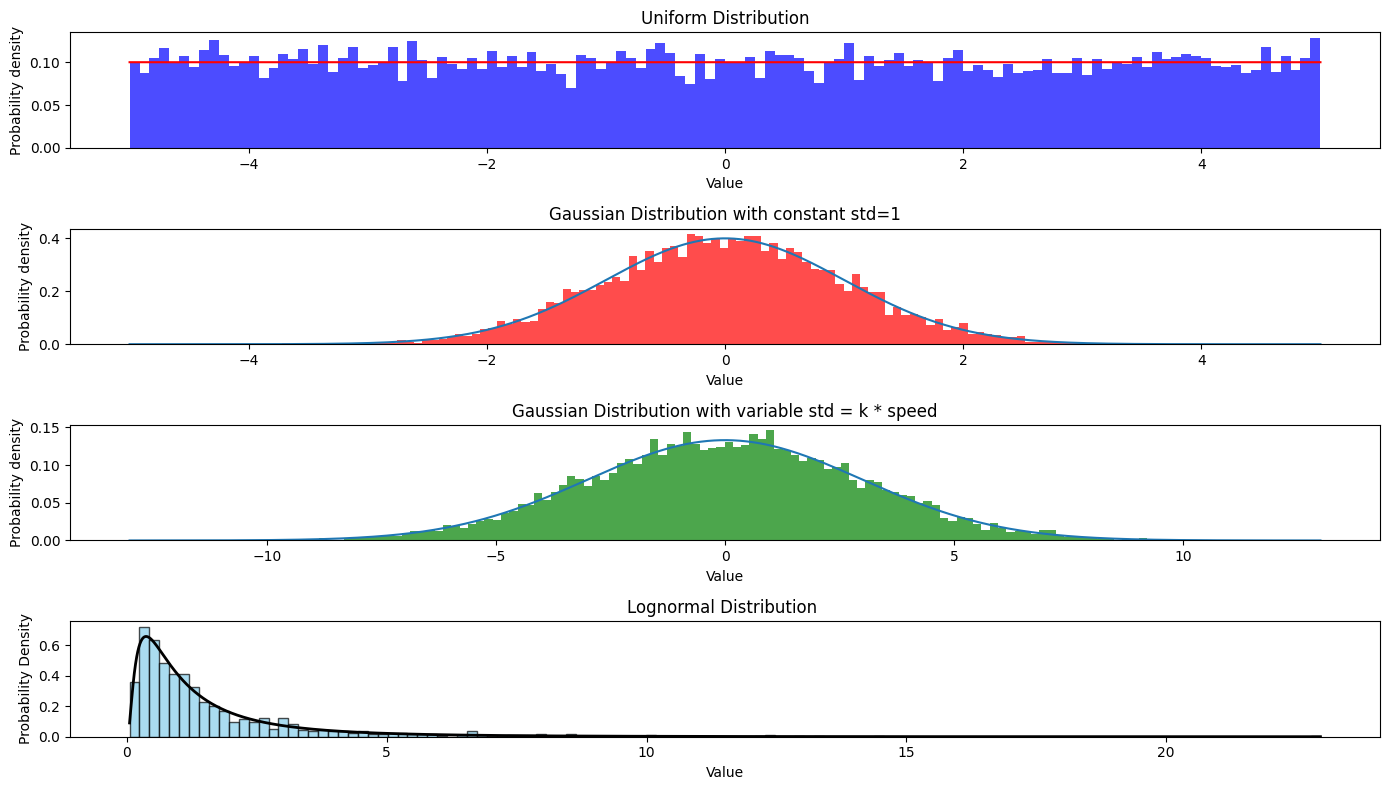

In [125]:
#TODO: Visualize the noise models using matplotlib

gps_noise_radius = 5
speed = 3

plt.figure(figsize=(14,8))

# Uniform distribution
uniform_data = np.random.uniform(-gps_noise_radius, gps_noise_radius, 10000)
plt.subplot(4, 1, 1)
plt.hist(uniform_data, bins=120, density=True, alpha=0.7, color='b')
x = np.linspace(-gps_noise_radius, gps_noise_radius, 10000)
plt.plot(x,[1/(2*gps_noise_radius) for _ in range(10000)], color='r')
plt.title('Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Probability density')

# Gaussian distribution
gaussian_data = np.random.normal(0, 1, 10000)
y1 = 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * x**2)
plt.subplot(4, 1, 2)
plt.hist(gaussian_data, bins=120, density=True, alpha=0.7, color='r')
plt.plot(x,y1)
plt.title('Gaussian Distribution with constant std=1')
plt.xlabel('Value')
plt.ylabel('Probability density')


# Gaussian distribution with varibale std
gaussian_data2 = np.random.normal(0, speed, 10000)
x = np.linspace(-13, 13, 10000)
y2 = 1 / (np.sqrt(2 * np.pi)*speed) * np.exp(-0.5 * x**2/(speed**2))
plt.subplot(4, 1, 3)
plt.hist(gaussian_data2, bins=120, density=True, alpha=0.7, color='g')
plt.plot(x,y2)
plt.title('Gaussian Distribution with variable std = k * speed')
plt.xlabel('Value')
plt.ylabel('Probability density')

# lognormal distribution
plt.subplot(4, 1, 4)
mu = 0
sigma = 1
s = np.random.lognormal(mu, sigma, 1000)
plt.hist(s, bins=120, density=True, alpha=0.7, color='skyblue', edgecolor='black')
xmin, xmax = min(s), max(s)
x = np.linspace(xmin, xmax, 10000)
pdf = (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2))
plt.plot(x, pdf, 'k-', linewidth=2)
plt.title('Lognormal Distribution ')
plt.xlabel('Value')
plt.ylabel('Probability Density')


plt.tight_layout()
plt.show()



In [126]:
#TODO: Visualize the noise models using kepler
gps_noise_radius = 3
k = 0.0005

# Uniform noise
noisy_example_ride1 = example_ride + np.random.uniform(-k*gps_noise_radius, k*gps_noise_radius, example_ride.shape[0]*example_ride.shape[1]).reshape(example_ride.shape[0],-1)
data = {
    'latitude': np.concatenate((example_ride[:,0],noisy_example_ride1[:,0])),
    'longitude': np.concatenate((example_ride[:,1],noisy_example_ride1[:,1])),
    'timestep': np.concatenate((np.arange(noisy_example_ride1.shape[0]),[100 for _ in range(noisy_example_ride1.shape[0])]))
    }

df = pd.DataFrame(data)
map_1 = KeplerGl(height=500, width=400)
map_1.add_data(data=df, name='example_ride')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [127]:
# Normal noise
gps_noise_radius = 3
k = 0.0001

noisy_example_ride2 = example_ride + np.random.normal(0,k* gps_noise_radius, example_ride.shape[0]*example_ride.shape[1]).reshape(example_ride.shape[0],-1)

data = {
    'latitude': np.concatenate((example_ride[:,0],noisy_example_ride2[:,0])),
    'longitude': np.concatenate((example_ride[:,1],noisy_example_ride2[:,1])),
    'timestep': np.concatenate((np.arange(noisy_example_ride2.shape[0]),[100 for _ in range(noisy_example_ride2.shape[0])]))
    }

df = pd.DataFrame(data)
map_2 = KeplerGl(height=500, width=600)
map_2.add_data(data=df, name='example_ride')
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [128]:
#TODO: Choose the best model (while you explain why you chose it)
def noise_adder(ride, speed, const):
  return ride + np.random.normal(0,const* speed ,size=ride.shape[0]*ride.shape[1]).reshape(ride.shape[0],-1)

**Explanation of my noise model:**

<font face="XB Zar" size=2><div dir=rtl>
برای مدل کردن نویز،بهترین انتخاب توزیع نرمال با میانگین صفر و واریانس برابر با سرعت ضربدر یک عدد ثابت می باشد. زیرا در سرعت های بالاتر این نویز واریانس بیشتری دارد و می تواند مقادیر بالاتری را اتخاذ کند.

توزیع هایی مانند توزیع lognormal هم مناسب نمی باشند زیرا همواره مقادیر مثبت را اتخاذ می کنند

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [129]:
#TODO: Visualize using kepler
# Normal noise
speed = 5
const = 0.00005

noisy_example_ride3 = noise_adder(example_ride, speed, const)

data = {
    'latitude': np.concatenate((example_ride[:,0],noisy_example_ride3[:,0])),
    'longitude': np.concatenate((example_ride[:,1],noisy_example_ride3[:,1])),
    'timestep': np.concatenate((np.arange(noisy_example_ride3.shape[0]),[100 for _ in range(noisy_example_ride3.shape[0])]))
    }

df = pd.DataFrame(data)
map_3 = KeplerGl(height=400, width=600)
map_3.add_data(data=df, name='example_ride')
map_3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [39]:
#TODO: create and store 20 noisy_rides as a dataset for our HMM to train on it and experiment with it
noisy_rides = []

for i in range(20):
  node1 = np.random.randint(0,pasdaran_streets.shape[0])
  node2 = np.random.randint(0,pasdaran_streets.shape[0])

  node1_lat,node1_lon = pasdaran_streets['u_lat'][node1], pasdaran_streets['u_lon'][node1]
  node2_lat,node2_lon = pasdaran_streets['u_lat'][node2], pasdaran_streets['u_lon'][node2]

  noisy_rides.append(find_shotest_path((node1_lat,node1_lon),(node2_lat,node2_lon),pasdaran_streets))


In [40]:
len(noisy_rides)

20

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

---

The `cross-track distance` formula is used in navigation and describes the perpendicular distance from a point to a line defined by two other points. This distance is often relevant in various fields, including aviation, marine navigation, and surveying.

The formula to calculate the cross-track distance is:

$$
\text{Cross-track distance} = \arcsin\left(\frac{\sin(\text{distance})}{\text{earth's radius}}\right) \times \text{earth's radius}$$


In this formula, "distance" represents the distance between the starting point and the nearest point on the `great circle` track.

The `great-circle distance` formula calculates the shortest distance between two points on the surface of a sphere, such as the Earth. It's often used in navigation and geographic information systems. The formula is based on spherical trigonometry and uses the latitude and longitude of the two points. In general, the formula is based on the haversine formula, which is given by:

$\text{Haversine formula: } \quad $

$$ haversin(\theta) = \sin^2\Bigg(\frac{d_{\text{lat}}}{2}\Bigg) + \cos(\text{lat}_1) \cdot \cos(\text{lat}_2) \cdot \sin^2\Bigg(\frac{d_{\text{long}}}{2}\Bigg)
$$



The Haversine formula for calculating the distance $d$ between two points on a sphere with radius $R$ is given by:

$$distance = 2R \arcsin(haversin(θ))$$


In [335]:
#TODO: Implement helper functions for your calculations

EARTH_RADIUS = 6371   # km

def cross_track_distance(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p):
    heversine_ = calculate_distance(lat_1, lon_1, lat_p, lon_p) / EARTH_RADIUS
    # heversine_ = calculate_distance(lat_1, lon_1, lat_p, lon_p)

    theta_1_p = calculate_bearing(lat_1, lon_1, lat_p, lon_p)
    theta_1_2 = calculate_bearing(lat_1, lon_1, lat_2, lon_2)
    return abs(math.asin(math.sin(heversine_) * math.sin(math.radians(theta_1_p) - math.radians(theta_1_2)))) * EARTH_RADIUS
    # return abs(math.asin(np.sin(heversine_)/ EARTH_RADIUS )) * EARTH_RADIUS


for a measurement $z_t$ and candidate road segment $r_i$, the latitude/longitude  point  on  the  road  segment  nearest  the
measurement is $x_{t,i}$ , for calculate it :

In [336]:
def state_finder(arc, noisy_point, df=pasdaran_streets):
    """
    Return the projection of the noisy point on the road segment 'arc'.
    """
    # unpacking the coordinates of the road segment 'arc'
    lat_1 = df[df['street_id'] == arc]['u_lat'].values[0]
    lon_1 = df[df['street_id'] == arc]['u_lon'].values[0]
    lat_2 = df[df['street_id'] == arc]['v_lat'].values[0]
    lon_2 = df[df['street_id'] == arc]['v_lon'].values[0]

    # coordinates of the noisy point
    lat_p, lon_p = noisy_point

    eps = 1e-06

    # calculate distance-related values
    distance_12 = calculate_distance(lat_1, lon_1, lat_2, lon_2) / EARTH_RADIUS
    distance_1p = calculate_distance(lat_1, lon_1, lat_p, lon_p) / EARTH_RADIUS
    distance_2p = calculate_distance(lat_2, lon_2, lat_p, lon_p) / EARTH_RADIUS

    # calculate angle-related values
    cos_p_12 = (math.cos(distance_2p) - math.cos(distance_1p) * math.cos(distance_12)) / (math.sin(distance_1p) * math.sin(distance_12) + eps)
    cos_p_21 = (math.cos(distance_1p) - math.cos(distance_2p) * math.cos(distance_12)) / (math.sin(distance_2p) * math.sin(distance_12) + eps)

    # handling extreme cases for cosine values
    if cos_p_12 > 1:
        cos_p_12 = 1
    elif cos_p_12 < -1:
        cos_p_12 = -1

    if cos_p_21 > 1:
        cos_p_21 = 1
    elif cos_p_21 < -1:
        cos_p_21 = -1

    # calculate angles in degrees
    deg_p_12 = math.degrees(math.acos(cos_p_12))
    deg_p_21 = math.degrees(math.acos(cos_p_21))

    # first check for the projection of the point on the road segment 'arc'
    if deg_p_12 > 90:
        return lat_1, lon_1

    if deg_p_21 > 90:
        return lat_2, lon_2

    # calculate cross-track distance and adjust the projection point's position
    cross_track_distance_ = cross_track_distance(lat_1, lon_1, lat_2, lon_2, lat_p, lon_p)
    dist1 = calculate_distance(lat_1, lon_1, lat_p, lon_p)
    dist2 = math.acos(math.cos(dist1 / EARTH_RADIUS) / math.cos(cross_track_distance_ / EARTH_RADIUS)) * EARTH_RADIUS
    new_lat, new_lon = move_towards(lat_1, lon_1, lat_2, lon_2, dist2)

    return new_lat, new_lon


**Emission probability :**

$$ p\left(z_t \mid r_i\right)=\frac{1}{\sqrt{2 \pi} \sigma_z} e^{-0.5\left(\frac{\left\|z_t-x_{t, i}\right\|_{\text {great circle }}}{\sigma_z}\right)^2} $$

In [354]:
def emisiion_prob(observation, projection, using_road_segment=False,road_segment=None):
  sigma = 12
  prob = 0

  if using_road_segment:
    x = state_finder(road_segment, observation)
    prob = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5* ((calculate_distance(*observation, *x)/sigma)**2) )

  else :
    prob = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5* ((calculate_distance(*observation, *projection)/sigma)**2) )

  return prob


**Transition Probability:**

$$
p\left(d_t\right)=\frac{1}{\beta} e^{-d_t / \beta}
$$

Here
$$
d_t=\left|\left\|z_t-z_{t+1}\right\|_{\text {great circle }}-\left\|x_{t, i^*}-x_{t+1, j} \cdot\right\|_{\text {route }}\right|
$$


<p style="color:yellow;"> This probability modeling is adopted from "Hidden Markov Map Matching Through Noise and Sparseness ,Paul Newson and John Krumm  Microsoft Research", where slight changes to use Transition and emission
probability functions.</p>




In [338]:
def add_node_to_graph(lat,lon,arc,df):
  # print('arc',arc)
  row = df[df['street_id'] == arc]

  u = row['u'].values[0]
  u_lat = row['u_lat'].values[0]
  u_lon = row['u_lon'].values[0]

  v = row['v'].values[0]
  v_lat = row['v_lat'].values[0]
  v_lon = row['v_lon'].values[0]

  length = row['length'].values[0]

  new_node_id = max(df['u'].values) + 100

  new_street1 = {'street_id':max(df['street_id'].values)+1, # don't care
                 'u':u,
                 'v': new_node_id,   # don't care
                 'length':calculate_distance(u_lat, u_lon, lat, lon),
                 'oneway':'yes'	,
                 'u_lat':	u_lat,
                 'u_lon':	u_lon,
                 'v_lat': lat,
                 'v_lon': lon}

  new_street2 = {'street_id':max(df['street_id'].values)+2, # don't care
                 'u':new_node_id,     # don't care
                 'v': v,
                 'length':calculate_distance(lat, lon,v_lat, v_lon),
                 'oneway':'yes'	,
                 'u_lat':	lat,
                 'u_lon':	lon,
                 'v_lat': v_lat,
                 'v_lon': v_lon}

  new_street1 = pd.DataFrame([new_street1])
  new_street2 = pd.DataFrame([new_street2])

  df = pd.concat((new_street1,new_street2,df), ignore_index=True)
  return df


In [339]:
# test the above function
copy_df = deepcopy(pasdaran_streets)
test_df = add_node_to_graph(35.971034,50.964462,687277053,copy_df)

In [340]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [341]:
test_df.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,1208111708,177540293,11194352585,50.242540,yes,35.771034,51.464462,35.971034,50.964462
1,1208111709,11194352585,423793585,50.227257,yes,35.971034,50.964462,35.770317,51.463833
2,5003747,423833948,423793584,90.570000,no,35.772419,51.465652,35.771748,51.465084
3,17099043,177540293,423832815,296.273000,yes,35.771034,51.464462,35.772175,51.461494
4,787945693,4429684144,423832815,62.573000,no,35.772636,51.461891,35.772175,51.461494


Claculate **route distance**:

In [342]:

def route_distance(z1, z2, arc1, arc2):
  """
  z1: noisy point 1,
  z2: noisy point 2,
  arc1: street_id1,
  arc2: street_id2

  return route_distance between z1 , z2 .
  """
  new_lat1, new_lon1 = state_finder(arc1, z1, pasdaran_streets)
  new_lat2, new_lon2 = state_finder(arc2, z2, pasdaran_streets)

  df = deepcopy(pasdaran_streets)
  df = add_node_to_graph(new_lat1, new_lon1,arc1,df)
  df = add_node_to_graph(new_lat2, new_lon2,arc2,df)

  # drop previous arc
  df = df.drop(df[df['street_id'] == arc1].index)
  df = df.drop(df[df['street_id'] == arc2].index)

  distance = find_shotest_length((new_lat1, new_lon1),(new_lat2, new_lon2), df)
  return distance

In [343]:
def find_shotest_length(start, end, graph) :
    """
    Find the shortest path length between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    def create_graph(df):
      graph = defaultdict(dict)
      for row in range(len(df)):
        graph[df.iloc[row]['u']][df.iloc[row]['v']] = df.iloc[row]['length']
        graph[df.iloc[row]['v']][df.iloc[row]['u']] = df.iloc[row]['length']

      else:
        for key in graph.keys():
          graph[key] = (graph[key],None)

        # check the created graph
        assert np.unique(np.concatenate((df['u'],df['v']))).shape[0] == len(graph.keys())
        return graph


    s_lat, s_lon = start
    d_lat, d_lon = end

    if graph[(graph['u_lat']==s_lat) & (graph['u_lon']==s_lon)]['u'].shape[0] > 0:
      start_node = graph[(graph['u_lat']==s_lat) & (graph['u_lon']==s_lon)]['u'].values[0]
    elif graph[(graph['v_lat']==s_lat) & (graph['v_lon']==s_lon)]['v'].shape[0] > 0:
      start_node = graph[(graph['v_lat']==s_lat) & (graph['v_lon']==s_lon)]['v'].values[0]

    if graph[(graph['u_lat']==d_lat) & (graph['u_lon']==d_lon)]['u'].shape[0] > 0:
      end_node = graph[(graph['u_lat']==d_lat) & (graph['u_lon']==d_lon)]['u'].values[0]
    elif graph[(graph['v_lat']==d_lat) & (graph['v_lon']==d_lon)]['v'].shape[0] > 0:
      end_node = graph[(graph['v_lat']==d_lat) & (graph['v_lon']==d_lon)]['v'].values[0]


    graph = create_graph(graph)
    # Initialize distances for all nodes
    distances = {node: np.inf for node in graph}
    distances[start_node] = 0

    queue = [(0, start_node)]

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        if current_node == end_node:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = graph[current_node][1]
            return distances[end_node]

        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node][0].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(queue, (distance, neighbor))
                graph[neighbor] = (graph[neighbor][0], current_node)

    return float('inf')



In [344]:
route_distance((35.171458,51.360865), (35.424864,54.416291), 36333153, 687277053)

0.09789761196649095

In [353]:
def transition_prob(z1,z2,x1,x2,arc1,arc2):
  # print(calculate_distance(*z1,*z2) , route_distance(x1,x2, arc1, arc2))
  d_t = abs(calculate_distance(*z1,*z2)*1000 - route_distance(x1,x2, arc1, arc2))/1000
  beta = 1
  prob = (1/beta)*np.exp(-d_t/beta)
  if prob < 1e-12:
    prob = 1e-12
  return prob

In [347]:
def find_nearest_segments(lat, lon, k):
  """
  return k nearest neighbor of the loaction (lat, lon)
  """
  greate_circle_dist = np.zeros(len(pasdaran_streets))

  for i in range(len(pasdaran_streets)):
      row = pasdaran_streets.iloc[i]
      proj_lat, proj_lon = state_finder(row['street_id'], (lat, lon))
      # print('aaa',state_finder(row['street_id'], (lat, lon)))
      greate_circle_dist[i] = calculate_distance(lat, lon, proj_lat, proj_lon)

  nearest_segments = np.argpartition(greate_circle_dist, k)[:k]
  nearest_segments = nearest_segments[np.argsort(greate_circle_dist[nearest_segments])]

  # print(greate_circle_dist)
  # print(np.argmin(greate_circle_dist))
  # print(np.min(greate_circle_dist))
  # print(nearest_segments)
  return nearest_segments

def find_nearest_projections(lat, lon,k):
  """
  return projection of the location on the k nearest neighbor of the loaction (lat, lon)
  """
  street_indices = find_nearest_segments(lat, lon, k)
  nearest_projections = []
  for index in street_indices:
      lat_proj, lon_proj = state_finder(pasdaran_streets.iloc[index]['street_id'], (lat, lon))
      nearest_projections.append((lat_proj, lon_proj,  pasdaran_streets.iloc[index]['street_id']))
  return nearest_projections     #( 'lat', 'lon', 'street_id')


# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [348]:
def mean_haversine_distance(denoised_points, original_points):
    total_distance = 0
    for denoised_point, original_point in tqdm(zip(denoised_points, original_points)):
        total_distance += calculate_distance(*denoised_point, *original_point)

    mean_distance = total_distance / len(denoised_points)
    return mean_distance


test_dataset_noisy = pd.read_csv("/content/drive/My Drive/AI/project/AI_project_phase_1/noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("/content/drive/My Drive/AI/project/AI_project_phase_1/original_test_dataset.csv")
denoised_dataset = deepcopy(test_dataset_noisy)

test_dataset_original.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771816,51.461178,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771458,51.460865,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770760,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.770027,51.459633,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769318,51.459030,0.00096,0.466


In [327]:
test_dataset_noisy.tail()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
336,0,19,21,4695529113,423832806,35.768428,51.454314,0.000897,0.517
337,0,19,22,4695529113,423832806,35.768312,51.455056,0.000897,0.517
338,0,19,23,4695529113,423832806,35.768044,51.456117,0.000897,0.517
339,0,19,24,4695529113,423832806,35.768549,51.456347,0.000897,0.517
340,0,19,25,4695529113,423832806,35.768851,51.456343,0.000897,0.517


In [355]:
# Define your HMM model
np.seterr(divide = 'ignore')

class HMM:
    def __init__(self, transition_prob, emission_prob, k):
        # self.states = states
        # self.observations = observations
        self.initial_prob = [1 for _ in range(k)]
        self.transition_prob = transition_prob
        self.emission_prob = emission_prob
        self.k = k


    def denoiser_viterbi(self,noisy_dataset):

        N = len(noisy_dataset)
        noisy_points = [(noisy_dataset.iloc[i]['lat'], noisy_dataset.iloc[i]['lon']) for i in range(N)]
        proj_points = [find_nearest_projections(noisy_points[i][0], noisy_points[i][1],k=self.k) for i in range(N)] #,k=self.k
        # proj_points_loc = [a[0][:2] for a in proj_points]
        # print(proj_points)
        # print('don0')

        proj_points_loc = []
        for row in proj_points:
          temp = []
          for triple in row:
            temp.append(triple[:2])
          proj_points_loc.append(temp)

        # print('done1')
        M_TABLE = np.zeros(self.k)

        # Initialization step
        for i in range(self.k):
            # initialization
            M_TABLE[i] = np.log(self.initial_prob[i]) + \
                      np.log(emisiion_prob(noisy_points[0], proj_points_loc[0][i]))
                      # emisiion_prob(observation, projection, using_road_segment=False,road_segment=None)

        # print('don1')
        # print(np.sum(M_TABLE))
        M_TABLE /= np.sum(M_TABLE)

        # Recursion step
        path = []
        for i in range(N - 1):
            path.append([])
            temp_prob = np.zeros(self.k)
            for j in range(self.k):
                prob = np.zeros(self.k)
                for t in range(self.k):
                    prob[t] = M_TABLE[t] + np.log(transition_prob(noisy_points[i], noisy_points[i + 1],
                                                    proj_points_loc[i][t], proj_points_loc[i + 1][j],
                                                   proj_points[i][t][-1], proj_points[i + 1][j][-1])) +\
                             np.log(emisiion_prob(noisy_points[i + 1], proj_points_loc[i + 1][j]))

                path[-1].append(np.argmax(prob))
                temp_prob[j] = max(prob)

            temp_prob /= np.sum(temp_prob)
            # print('aaaa',np.sum(temp_prob))
            M_TABLE = temp_prob.copy()

        # Termination step
        best_path_pointer = np.argmax(M_TABLE)

        # Backtrace to find the best path
        best_path = [best_path_pointer]
        for i in range(len(path)):
            best_path.append(path[i][best_path[-1]])
        best_path.reverse()

        # Convert the best path to denoised points
        denoised_points = [[proj_points[i][best_path[i]][0], proj_points[i][best_path[i]][1]] for i in range(N)]
        return denoised_points



hmm_model = HMM(transition_prob, emisiion_prob,2)


In [356]:
# Iterate through each noisy ride and denoise it, then calculate the mean haversine distance between the denoised ride and the original ride
# Report the Average Mean Haversine Distance for all the rides in the test dataset
# This should be of order 10^-3

num_trip = test_dataset_noisy['trip_id'].max() + 1
denoised_rides = []
mhd_list = []

for i in tqdm(range(num_trip)):
    if i == 9:
      continue
    noisy_trip = test_dataset_noisy[test_dataset_noisy['trip_id'] == i]
    org_trip = test_dataset_original[test_dataset_original['trip_id'] == i]

    org_ride = [(org_trip.iloc[j]['lat'], org_trip.iloc[j]['lon']) for j in range(len(org_trip))]
    denoised_ride = hmm_model.denoiser_viterbi(noisy_trip)
    denoised_rides.append(denoised_ride)

    mhd = mean_haversine_distance(denoised_ride, org_ride)
    print(f'MHD for ride {i}: {mhd}')
    mhd_list.append(mhd)

print(f'Average Mean Haversine Distance for all the rides: {np.mean(mhd_list)}')

  0%|          | 0/20 [00:00<?, ?it/s]
20it [00:00, 79437.58it/s]
  5%|▌         | 1/20 [02:35<49:09, 155.25s/it]

MHD for ride 0: 0.011279021672379097



16it [00:00, 72082.56it/s]
 10%|█         | 2/20 [04:51<43:11, 144.00s/it]

MHD for ride 1: 0.028073647897303714



30it [00:00, 97617.63it/s]
 15%|█▌        | 3/20 [08:43<52:08, 184.02s/it]

MHD for ride 2: 0.01996436849532957



7it [00:00, 37117.73it/s]
 20%|██        | 4/20 [09:34<35:07, 131.72s/it]

MHD for ride 3: 0.024116576313891934



3it [00:00, 7663.16it/s]
 25%|██▌       | 5/20 [09:53<22:46, 91.11s/it] 

MHD for ride 4: 0.003116879945760761



58it [00:00, 129882.34it/s]
 30%|███       | 6/20 [17:28<50:08, 214.93s/it]

MHD for ride 5: 0.026957775642689405



38it [00:00, 125104.83it/s]
 35%|███▌      | 7/20 [23:20<56:13, 259.53s/it]

MHD for ride 6: 0.012971305134804115



9it [00:00, 46374.37it/s]
 40%|████      | 8/20 [24:46<40:50, 204.22s/it]

MHD for ride 7: 0.014412151817484968



10it [00:00, 48714.33it/s]
 45%|████▌     | 9/20 [26:05<30:18, 165.33s/it]

MHD for ride 8: 0.016872703517066198



10it [00:00, 56299.38it/s]
 55%|█████▌    | 11/20 [27:20<15:45, 105.03s/it]

MHD for ride 10: 0.023395589925033718



7it [00:00, 42799.02it/s]
 60%|██████    | 12/20 [28:12<12:13, 91.63s/it] 

MHD for ride 11: 0.01707414830231003



13it [00:00, 60854.86it/s]
 65%|██████▌   | 13/20 [29:50<10:52, 93.17s/it]

MHD for ride 12: 0.01856281438173675



3it [00:00, 17797.61it/s]
 70%|███████   | 14/20 [30:08<07:15, 72.66s/it]

MHD for ride 13: 0.001019283059746567



29it [00:00, 108408.93it/s]
 75%|███████▌  | 15/20 [34:08<09:58, 119.60s/it]

MHD for ride 14: 0.01844018954045876



16it [00:00, 75403.22it/s]
 80%|████████  | 16/20 [36:25<08:18, 124.62s/it]

MHD for ride 15: 0.02311781259426535



12it [00:00, 54708.31it/s]
 85%|████████▌ | 17/20 [37:54<05:42, 114.23s/it]

MHD for ride 16: 0.01908936590443325



16it [00:00, 68900.27it/s]
 90%|█████████ | 18/20 [39:55<03:52, 116.40s/it]

MHD for ride 17: 0.02051070554393858



18it [00:00, 72803.73it/s]
 95%|█████████▌| 19/20 [42:11<02:02, 122.12s/it]

MHD for ride 18: 0.021647720563588674



26it [00:00, 73783.43it/s]
100%|██████████| 20/20 [45:51<00:00, 137.58s/it]

MHD for ride 19: 0.01735425224565171
Average Mean Haversine Distance for all the rides: 0.017788226973572272


# Save the `denoised_dataset.csv`

In [357]:
c = 0
for i in range(num_trip-1):
  for j in range(len(denoised_rides[i])):
      denoised_dataset.at[c, 'lat'] = denoised_rides[i][j][0]
      denoised_dataset.at[c, 'lon'] = denoised_rides[i][j][1]
      c += 1

In [358]:
denoised_dataset.to_csv('/content/drive/My Drive/AI/project/AI_project_phase_1/denoised_test_dataset.csv', index=False)

# Visulize noisy and denoised rides loactions

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [359]:
def compare_org_and_noisy(orgdf,noisydf,trip_index):
  df = pd.concat((orgdf[orgdf['trip_id']==trip_index],noisydf[noisydf['trip_id']==trip_index]), ignore_index=True)
  df['timestep'] =  np.concatenate((np.arange(orgdf[orgdf['trip_id']==trip_index].shape[0]),[100 for _ in range(orgdf[orgdf['trip_id']==trip_index].shape[0])]))
  map = KeplerGl(height=600, width=600)
  map.add_data(data= df[['lat','lon'	,'timestep']] , name='example_ride')
  return map



def compare_org_and_noisy2(trip1,orgdf,trip_index):
  df = orgdf[orgdf['trip_id']==trip_index]

  data = {
      'latitude': np.concatenate((trip1[:,0],df['lat'].values)),
      'longitude': np.concatenate((trip1[:,1],df['lon'].values)),
      'timestep': np.concatenate((np.arange(trip1.shape[0]),[100 for _ in range(trip1.shape[0])]))
      }

  df = pd.DataFrame(data)
  map_1 = KeplerGl(height=600, width=800)
  map_1.add_data(data=df, name='example_ride')

  return map_1

## test_dataset_original vs test_dataset_nois

In [360]:
compare_org_and_noisy(test_dataset_original,test_dataset_noisy,0)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [361]:
compare_org_and_noisy(test_dataset_original,test_dataset_noisy,1)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [362]:
compare_org_and_noisy(test_dataset_original,test_dataset_noisy,2)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

## test_dataset_original vs denoised_dataset

In [363]:
compare_org_and_noisy2(np.array(denoised_rides[0]),test_dataset_original,0)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [364]:
compare_org_and_noisy2(np.array(denoised_rides[1]),test_dataset_original,1)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [365]:
compare_org_and_noisy2(np.array(denoised_rides[2]),test_dataset_original,2)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [367]:
compare_org_and_noisy2(np.array(denoised_rides[7]),test_dataset_original,7)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'example_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'colu…

**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)

In [368]:
print(f'Average Mean Haversine Distance for all the rides: {np.mean(mhd_list)}')

Average Mean Haversine Distance for all the rides: 0.017788226973572272
